In [1]:
!pip install -U tensorflow
!pip install -U sklearn
!pip install transformers

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.4.0)
Requirement already up-to-date: sklearn in /usr/local/lib/python3.6/dist-packages (0.0)
     |████████████████████████████████| 1.8MB 8.3MB/s 
     |████████████████████████████████| 2.9MB 46.1MB/s 
     |████████████████████████████████| 890kB 60.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=0c764fa94401f90fe8b79aca1abedc89af91dd1e0ff67bbb560bf476da5087f0
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk import tokenize
from wordcloud import WordCloud
import seaborn as sns
import itertools
import nltk
nltk.download('punkt')
import torch
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
# import torchtextp

tf.config.list_physical_devices('GPU')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
PATH = "/content/gdrive/My Drive/FakeNewsDetection/"

Mounted at /content/gdrive


In [4]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

# device = tf.test.gpu_device_name()


In [5]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

In [6]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english', do_lower_case=True)

# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX, is_target = True)
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float,  is_target = True)

# label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
# text_field = Field(sequential=False, use_vocab=False,dtype=torch.float, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
#                    fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('', None),('text', text_field), ('label', label_field)]




In [7]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

# Dataset 1

In [ ]:

# TabularDataset
fake_data = pd.read_csv(os.path.join(PATH, "Dataset/Fake.csv"))
true_data = pd.read_csv(os.path.join(PATH, "Dataset/True.csv"))
fake_data['label'] = 'fake'
true_data['label'] = 'true'
news_data = pd.concat([fake_data, true_data]).reset_index(drop = True)
news_data = shuffle(news_data)
news_data = news_data.reset_index(drop=True)
news_data["text"] = news_data["title"] + " " + news_data["text"]
news_data.drop(["title"],axis=1,inplace=True)
X_train,X_test,Y_train,Y_test = train_test_split(news_data['text'], news_data.label, test_size=0.25, random_state=42)
X_train,X_validation,Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)


In [ ]:
training = {}
test = {}
validation = {}

training['text'] = X_train
training['label'] = Y_train
training = pd.DataFrame(data=training)

test['text'] = X_test
test['label'] = Y_test
test = pd.DataFrame(data=test)

validation['text'] = X_validation
validation['label'] = Y_validation
validation = pd.DataFrame(data=validation)

training =training.reset_index(drop=True)
validation = validation.reset_index(drop=True)
test= test.reset_index(drop=True)

In [ ]:
for i in range(len(training)):
    if training['label'][i] == "true":
        training['label'][i] = 0
    else:
        training['label'][i] = 1

In [ ]:
for i in range(len(validation)):
    if validation['label'][i] == "true":
        validation['label'][i] = 0
    else:
        validation['label'][i] = 1

In [ ]:
for i in range(len(test)):
    if test['label'][i] == "true":
        test['label'][i] = 0
    else:
        test['label'][i] = 1

In [ ]:
training.to_csv(os.path.join(PATH, "Dataset/train.csv"), columns=['text', 'label'])
validation.to_csv(os.path.join(PATH, "Dataset/validation.csv"), columns=['text', 'label'])
test.to_csv(os.path.join(PATH, "Dataset/test.csv"), columns=['text', 'label'])

In [ ]:
train, valid, test = TabularDataset.splits(path=os.path.join(PATH, "Dataset"), train='train.csv', validation='validation.csv',
                                           test='test.csv', format='CSV', fields=fields, skip_header=True)

In [ ]:
# Iterators

train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=False)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort = False)
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

In [ ]:
valid.fields

In [ ]:
m = next(iter(train_iter))

In [ ]:

model = BERT().to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=2e-5)

In [ ]:
load_checkpoint(os.path.join(PATH, "Dataset/") + '/model.pt', model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== /content/gdrive/My Drive/FakeNewsDetection/Dataset//model.pt


0.002286657052098259

In [ ]:
# Training Function

def trainn(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = os.path.join(PATH, "Dataset"),
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for element in train_loader:
            label = element.label
            text = element.text
            label = label.type(torch.LongTensor)           
            label = label.to(device)
            text = text.type(torch.LongTensor)  
            text = text.to(device)
            loss,_ = model(text, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for element in valid_loader:
                        label = element.label
                        text = element.text
                        label = label.type(torch.LongTensor)           
                        label = label.to(device)
                        text = text.type(torch.LongTensor)  
                        text = text.to(device)
                        loss,_ = model(text, label)
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
                break
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')



In [ ]:
trainn(model=model, optimizer=optimizer)

Epoch [1/5], Step [789/7895], Train Loss: 0.0242, Valid Loss: 0.0023
Model saved to ==> /content/gdrive/My Drive/FakeNewsDetection/Dataset/model.pt
Model saved to ==> /content/gdrive/My Drive/FakeNewsDetection/Dataset/metrics.pt


In [ ]:
global_steps_list

[789]

Model loaded from <== /content/gdrive/My Drive/FakeNewsDetection/Dataset/metrics.pt


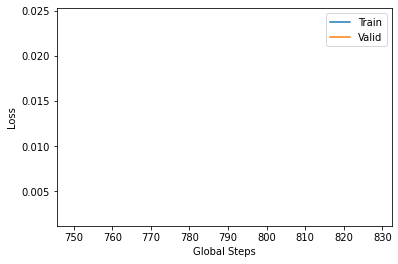

In [ ]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(os.path.join(PATH, "Dataset/metrics.pt"))
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
best_model = BERT().to(device)

load_checkpoint(os.path.join(PATH, "Dataset/") + '/model.pt', best_model)

In [ ]:
y_pred = []
y_true = []

best_model.eval()
with torch.no_grad():
    for element in test_iter:
            label = element.label
            text = element.text
            labels = label.type(torch.LongTensor)           
            labels = labels.to()
            text = text.type(torch.LongTensor)  
            text = text.to()
            output = best_model(text, labels)

            _, output = output
            y_pred.extend(torch.argmax(output, 1).tolist())
            y_true.extend(labels.tolist())
    
print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))


Classification Report:
              precision    recall  f1-score   support

           1     0.9985    1.0000    0.9992      5923
           0     1.0000    0.9983    0.9992      5302

    accuracy                         0.9992     11225
   macro avg     0.9992    0.9992    0.9992     11225
weighted avg     0.9992    0.9992    0.9992     11225



TypeError: ignored

Classification Report:
              precision    recall  f1-score   support

           1     0.9985    1.0000    0.9992      5923
           0     1.0000    0.9983    0.9992      5302

    accuracy                         0.9992     11225
   macro avg     0.9992    0.9992    0.9992     11225
weighted avg     0.9992    0.9992    0.9992     11225



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


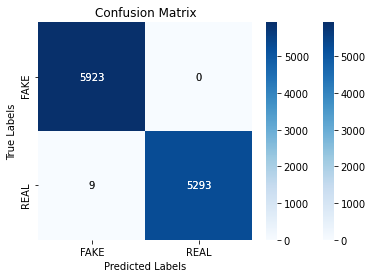

In [ ]:
import sklearn
cm = sklearn.metrics.confusion_matrix(y_true, y_pred, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
    
evaluate(best_model, test_iter)

## Transfer learning - Dataset 2

In [ ]:
best_model = BERT().to(device)

load_checkpoint(os.path.join(PATH, "Dataset/") + '/model.pt', best_model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== /content/gdrive/My Drive/FakeNewsDetection/Dataset//model.pt


0.002286657052098259

In [ ]:
import csv
csv.field_size_limit(250000)

250000

In [ ]:
train = pd.read_csv(os.path.join(PATH, "Dataset2/train2.csv"))
validation = pd.read_csv(os.path.join(PATH, "Dataset2/validation2.csv"))
test = pd.read_csv(os.path.join(PATH, "Dataset2/test2.csv"))


In [ ]:
df = pd.concat([train, validation, test], ignore_index=True)

In [ ]:
df.to_csv(os.path.join(PATH, "Dataset2/train_tf.csv"))

In [ ]:
df = df.drop("Unnamed: 0", axis = 1)

In [ ]:
train, valid, test = TabularDataset.splits(path=os.path.join(PATH, "Dataset2"), train='train2.csv', validation='validation2.csv',
                                           test='train_tf.csv', format='CSV', fields=fields, skip_header=True)

In [ ]:
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

In [ ]:
y_pred = []
y_true = []

best_model.eval()
with torch.no_grad():
    for element in test_iter:
            label = element.label
            text = element.text
            labels = label.type(torch.LongTensor)           
            labels = labels.to()
            text = text.type(torch.LongTensor)  
            text = text.to()
            output = best_model(text, labels)

            _, output = output
            y_pred.extend(torch.argmax(output, 1).tolist())
            y_true.extend(labels.tolist())
    
print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))


Classification Report:
              precision    recall  f1-score   support

           1     0.5818    0.9889    0.7326     10413
           0     0.9626    0.2875    0.4427     10387

    accuracy                         0.6386     20800
   macro avg     0.7722    0.6382    0.5877     20800
weighted avg     0.7720    0.6386    0.5878     20800



[Text(0, 0.5, 'FAKE'), Text(0, 1.5, 'REAL')]

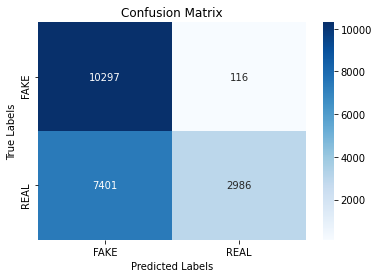

In [ ]:
import sklearn
cm = sklearn.metrics.confusion_matrix(y_true, y_pred, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
    

## Transfer learning - Dataset 3

In [ ]:
best_model = BERT().to(device)

load_checkpoint(os.path.join(PATH, "Dataset/") + '/model.pt', best_model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== /content/gdrive/My Drive/FakeNewsDetection/Dataset//model.pt


0.002286657052098259

In [ ]:
import csv
csv.field_size_limit(250000)
X_test = None
X_test = pd.read_csv(os.path.join(PATH, "Dataset3/smaller_dataset.csv"))

In [ ]:
# X_test = X_test.drop("Unnamed: 0", axis = 1)

In [ ]:
for i in range(len(X_test['type'])):
    if X_test['type'][i] == "true":
        X_test['type'][i] = 0
    else:
        X_test['type'][i] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
X_test = X_test.drop("Unnamed: 0", axis = 1)
X_test

,type,content
0,0,Israel's First International Bank Q3 profit ri...
1,0,"Warburg Pincus, Vietnam's VinaCapial in $300 m..."
2,0,Wal-Mart shares fall after revenue miss - Mark...
3,0,Tesla cars will get even quicker through a sof...
4,0,Teva Pharm Q3 beats estimates as acquisition l...
...,...,...
49996,1,Secret Occult Government Of The World Does Not...
49997,1,"202,000,000,000 Hz Schumann Resonance: Earth Q..."
49998,1,Extraterrestrial Says Prince Ascended But Non-...
49999,1,Trump Calls For Arrest Of Huma Abedin As Hilla...


In [ ]:
X_test.to_csv(os.path.join(PATH, "Dataset3/smaller_dataset_tf.csv"), columns=['type', 'content'])

In [ ]:
# Fields
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX, is_target = True)
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float,  is_target = True)

# label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
# text_field = Field(sequential=False, use_vocab=False,dtype=torch.float, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
#                    fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('', None),('content', text_field), ('type', label_field)]


In [ ]:
train, valid, test = TabularDataset.splits(path=os.path.join(PATH, "Dataset3"), train='smaller_dataset_tf.csv', validation='smaller_dataset_tf.csv',
                                           test='smaller_dataset_tf.csv', format='CSV', fields=fields, skip_header=True)

In [ ]:
y_pred = []
y_true = []

best_model.eval()
with torch.no_grad():
    for element in test_iter:
            label = element.type
            text = element.content
            labels = label.type(torch.LongTensor)           
            labels = labels.to()
            text = text.type(torch.LongTensor)  
            text = text.to()
            output = best_model(text, labels)

            _, output = output
            y_pred.extend(torch.argmax(output, 1).tolist())
            y_true.extend(labels.tolist())
    
print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))


ValueError: ignored

[Text(0, 0.5, 'FAKE'), Text(0, 1.5, 'REAL')]

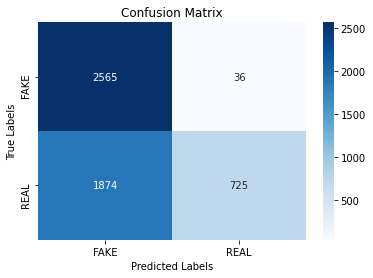

In [ ]:
import sklearn
cm = sklearn.metrics.confusion_matrix(y_true, y_pred, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
    

# Dataset 2

In [ ]:
# TabularDataset
news_data = pd.read_csv(os.path.join(PATH, "Dataset2/train.csv"))
news_data = shuffle(news_data)
news_data = news_data.reset_index(drop=True)
news_data["text"] = news_data["title"] + " " + news_data["text"]
news_data.drop(["title"],axis=1,inplace=True)
X_train,X_test,Y_train,Y_test = train_test_split(news_data['text'], news_data.label, test_size=0.25, random_state=42)
X_train,X_validation,Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)


In [ ]:
training = {}
test = {}
validation = {}

training['text'] = X_train
training['label'] = Y_train
training = pd.DataFrame(data=training)

test['text'] = X_test
test['label'] = Y_test
test = pd.DataFrame(data=test)

validation['text'] = X_validation
validation['label'] = Y_validation
validation = pd.DataFrame(data=validation)

training =training.reset_index(drop=True)
validation = validation.reset_index(drop=True)
test= test.reset_index(drop=True)

In [ ]:
training.to_csv(os.path.join(PATH, "Dataset2/train2.csv"), columns=['text', 'label'])
validation.to_csv(os.path.join(PATH, "Dataset2/validation2.csv"), columns=['text', 'label'])
test.to_csv(os.path.join(PATH, "Dataset2/test2.csv"), columns=['text', 'label'])

In [ ]:
import csv
csv.field_size_limit(250000)

131072

In [ ]:
train, valid, test = TabularDataset.splits(path=os.path.join(PATH, "Dataset2"), train='train2.csv', validation='validation2.csv',
                                           test='test2.csv', format='CSV', fields=fields, skip_header=True)

In [ ]:
# Iterators

train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=False)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort = False)
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

In [ ]:
model = BERT().to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=2e-5)

In [ ]:
# load_checkpoint(os.path.join(PATH, "Dataset2/") + '/model2.pt', model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== /content/gdrive/My Drive/FakeNewsDetection/Dataset//model.pt


0.002286657052098259

In [ ]:
# Training Function

def trainn(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = os.path.join(PATH, "Dataset2"),
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for element in train_loader:
            label = element.label
            text = element.text
            label = label.type(torch.LongTensor)           
            label = label.to(device)
            text = text.type(torch.LongTensor)  
            text = text.to(device)
            loss,_ = model(text, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for element in valid_loader:
                        label = element.label
                        text = element.text
                        label = label.type(torch.LongTensor)           
                        label = label.to(device)
                        text = text.type(torch.LongTensor)  
                        text = text.to(device)
                        loss,_ = model(text, label)
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
                break
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')



In [ ]:
trainn(model=model, optimizer=optimizer)

Epoch [1/5], Step [366/3660], Train Loss: 0.0202, Valid Loss: 0.0155
Model saved to ==> /content/gdrive/My Drive/FakeNewsDetection/Dataset2/model.pt
Model saved to ==> /content/gdrive/My Drive/FakeNewsDetection/Dataset2/metrics.pt


KeyboardInterrupt: ignored

In [ ]:
load_checkpoint(os.path.join(PATH, "Dataset2/") + '/model.pt', model)

Model loaded from <== /content/gdrive/My Drive/FakeNewsDetection/Dataset2//model.pt


0.015484609582449967

Model loaded from <== /content/gdrive/My Drive/FakeNewsDetection/Dataset2/metrics.pt


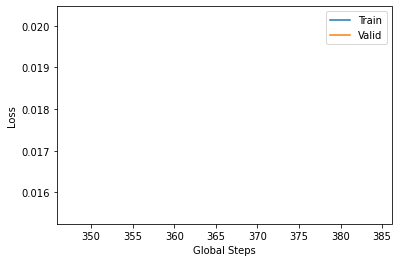

In [ ]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(os.path.join(PATH, "Dataset2/metrics.pt"))
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
best_model = BERT().to(device)

load_checkpoint(os.path.join(PATH, "Dataset2/") + '/model.pt', best_model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== /content/gdrive/My Drive/FakeNewsDetection/Dataset2//model.pt


0.015484609582449967

In [ ]:
y_pred = []
y_true = []

best_model.eval()
with torch.no_grad():
    for element in test_iter:
            label = element.label
            text = element.text
            labels = label.type(torch.LongTensor)           
            labels = labels.to()
            text = text.type(torch.LongTensor)  
            text = text.to()
            output = best_model(text, labels)

            _, output = output
            y_pred.extend(torch.argmax(output, 1).tolist())
            y_true.extend(labels.tolist())
    
print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))


Classification Report:
              precision    recall  f1-score   support

           1     0.9973    0.9950    0.9962      2601
           0     0.9950    0.9973    0.9962      2599

    accuracy                         0.9962      5200
   macro avg     0.9962    0.9962    0.9962      5200
weighted avg     0.9962    0.9962    0.9962      5200



[Text(0, 0.5, 'FAKE'), Text(0, 1.5, 'REAL')]

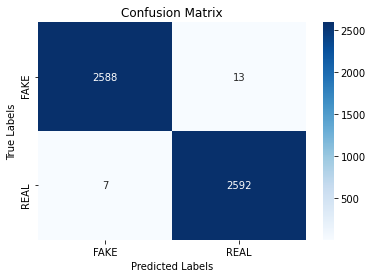

In [ ]:
import sklearn
cm = sklearn.metrics.confusion_matrix(y_true, y_pred, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
    

## Transfer learning - Dataset 1

In [ ]:
best_model = BERT().to(device)

load_checkpoint(os.path.join(PATH, "Dataset2/") + '/model.pt', best_model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== /content/gdrive/My Drive/FakeNewsDetection/Dataset2//model.pt


0.015484609582449967

In [ ]:
import csv
csv.field_size_limit(250000)

131072

In [ ]:
train, valid, test = TabularDataset.splits(path=os.path.join(PATH, "Dataset"), train='train.csv', validation='train.csv',
                                           test='train.csv', format='CSV', fields=fields, skip_header=True)

In [ ]:
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

In [ ]:
y_pred = []
y_true = []

best_model.eval()
with torch.no_grad():
    for element in test_iter:
            label = element.label
            text = element.text
            labels = label.type(torch.LongTensor)           
            labels = labels.to()
            text = text.type(torch.LongTensor)  
            text = text.to()
            output = best_model(text, labels)

            _, output = output
            y_pred.extend(torch.argmax(output, 1).tolist())
            y_true.extend(labels.tolist())
    
print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))


Classification Report:
              precision    recall  f1-score   support

           1     0.5214    0.9955    0.6844     13166
           0     0.5000    0.0049    0.0097     12088

    accuracy                         0.5213     25254
   macro avg     0.5107    0.5002    0.3470     25254
weighted avg     0.5112    0.5213    0.3614     25254



[Text(0, 0.5, 'FAKE'), Text(0, 1.5, 'REAL')]

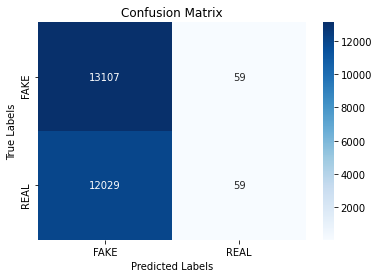

In [ ]:
import sklearn
cm = sklearn.metrics.confusion_matrix(y_true, y_pred, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
ax.yaxis.set_ticklabels(['FAKE', 'REAL'])

# Dataset 3

In [8]:
# Fields
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX, is_target = True)
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float,  is_target = True)

# label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
# text_field = Field(sequential=False, use_vocab=False,dtype=torch.float, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
#                    fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [ ('content', text_field), ('type', label_field)]


In [ ]:

# TabularDataset
news_data = pd.read_csv(os.path.join(PATH, "Dataset3/smaller_dataset.csv"))
news_data = shuffle(news_data)
news_data = news_data.reset_index(drop=True)


In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(news_data['content'], news_data['type'], test_size=0.25, random_state=42)
X_train,X_validation,Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)


In [ ]:
training = {}
test = {}
validation = {}

training['content'] = X_train
training['type'] = Y_train
training = pd.DataFrame(data=training)

test['content'] = X_test
test['type'] = Y_test
test = pd.DataFrame(data=test)

validation['content'] = X_validation
validation['type'] = Y_validation
validation = pd.DataFrame(data=validation)

training =training.reset_index(drop=True)
validation = validation.reset_index(drop=True)
test= test.reset_index(drop=True)

In [ ]:
for i in range(len(training)):
    if training['type'][i] == "true":
        training['type'][i] = 0
    else:
        training['type'][i] = 1

In [ ]:
for i in range(len(validation)):
    if validation['type'][i] == "true":
        validation['type'][i] = 0
    else:
        validation['type'][i] = 1

In [ ]:
for i in range(len(test)):
    if test['type'][i] == "true":
        test['type'][i] = 0
    else:
        test['type'][i] = 1

In [ ]:
training.to_csv(os.path.join(PATH, "Dataset3/train3.csv"), columns=['type', 'content'])
validation.to_csv(os.path.join(PATH, "Dataset3/validation3.csv"), columns=['type', 'content'])
test.to_csv(os.path.join(PATH, "Dataset3/test3.csv"), columns=['type', 'content'])

In [9]:
x = pd.read_csv(os.path.join(PATH, "Dataset3/test3.csv"))
x

,Unnamed: 0,type,content
0,0,1,Left-handed or Right? Left-handed or Right?\n\...
1,1,0,"On website, thousands of Americans pledge to s..."
2,2,1,And Then There Was None (Backwardation) And Th...
3,3,0,"After 0-4 Trip, Casey Asks Other Nets to Help ..."
4,4,0,WATCH: Baltimore Cop Charged in Freddie Gray C...
...,...,...,...
12496,12496,1,URGENT! Stop the FCCâs plot to take over the...
12497,12497,0,The people of a small Slovenian town are excit...
12498,12498,0,Senior EU Official Praises Portugal's Economic...
12499,12499,1,U.S. and Saudis Causing Hundreds of Thousands ...


In [10]:
train, valid, test = TabularDataset.splits(path=os.path.join(PATH, "Dataset3"), train='train3.csv', validation='validation3.csv',
                                           test='test3.csv', format='CSV', fields=fields, skip_header=True)

In [11]:
# Iterators

train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=False)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort = False)
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

In [12]:

model = BERT().to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [13]:
optimizer = optim.Adam(model.parameters(), lr=2e-5)

In [14]:
load_checkpoint(os.path.join(PATH, "Dataset3/") + '/model.pt', model)

Model loaded from <== /content/gdrive/My Drive/FakeNewsDetection/Dataset3//model.pt


0.6937274620598086

In [15]:
# Training Function

def trainn(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = os.path.join(PATH, "Dataset3"),
          best_valid_loss = 0.6955):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for element in train_loader:
            label = element.type
            text = element.content
            label = label.type(torch.LongTensor)           
            label = label.to(device)
            text = text.type(torch.LongTensor)  
            text = text.to(device)
            loss,_ = model(text, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for element in valid_loader:
                        label = element.type
                        text = element.content
                        label = label.type(torch.LongTensor)           
                        label = label.to(device)
                        text = text.type(torch.LongTensor)  
                        text = text.to(device)
                        loss,_ = model(text, label)
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')



In [16]:
trainn(model=model, optimizer=optimizer)

Epoch [1/5], Step [879/8790], Train Loss: 0.7006, Valid Loss: 0.6930
Model saved to ==> /content/gdrive/My Drive/FakeNewsDetection/Dataset3/model.pt
Model saved to ==> /content/gdrive/My Drive/FakeNewsDetection/Dataset3/metrics.pt


Model loaded from <== /content/gdrive/My Drive/FakeNewsDetection/Dataset3/metrics.pt


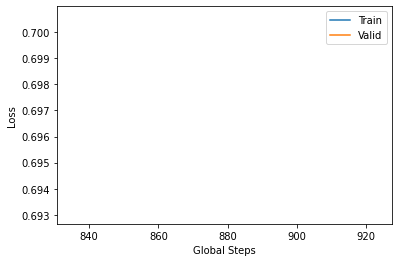

In [17]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(os.path.join(PATH, "Dataset3/metrics.pt"))
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
best_model = BERT().to(device)

load_checkpoint(os.path.join(PATH, "Dataset3/") + '/model.pt', best_model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== /content/gdrive/My Drive/FakeNewsDetection/Dataset3//model.pt


0.6930365351890134

In [ ]:
y_pred = []
y_true = []

best_model.eval()
with torch.no_grad():
    for element in test_iter:
            label = element.type
            text = element.content
            labels = label.type(torch.LongTensor)           
            labels = labels.to()
            text = text.type(torch.LongTensor)  
            text = text.to()
            output = best_model(text, labels)

            _, output = output
            y_pred.extend(torch.argmax(output, 1).tolist())
            y_true.extend(labels.tolist())
    
print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))


[Text(0, 0.5, 'FAKE'), Text(0, 1.5, 'REAL')]

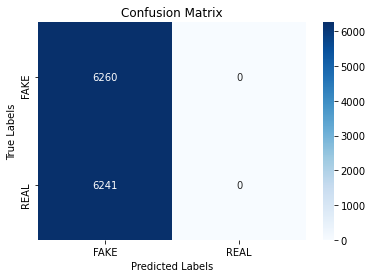

In [31]:
import sklearn
cm = sklearn.metrics.confusion_matrix(y_true, y_pred, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
    

## Transfer learning - Dataset 2

In [35]:
best_model = BERT().to(device)

load_checkpoint(os.path.join(PATH, "Dataset3/") + '/model.pt', best_model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== /content/gdrive/My Drive/FakeNewsDetection/Dataset3//model.pt


0.6937274620598086

In [36]:
import csv
csv.field_size_limit(250000)

131072

In [37]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english', do_lower_case=True)


# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX, is_target = True)
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float,  is_target = True)

# label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
# text_field = Field(sequential=False, use_vocab=False,dtype=torch.float, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
#                    fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('', None),('text', text_field), ('label', label_field)]




In [38]:
train, valid, test = TabularDataset.splits(path=os.path.join(PATH, "Dataset2"), train='train2.csv', validation='validation2.csv',
                                           test='train_tf.csv', format='CSV', fields=fields, skip_header=True)

In [39]:
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

In [40]:
y_pred = []
y_true = []

best_model.eval()
with torch.no_grad():
    for element in test_iter:
            label = element.label
            text = element.text
            labels = label.type(torch.LongTensor)           
            labels = labels.to()
            text = text.type(torch.LongTensor)  
            text = text.to()
            output = best_model(text, labels)

            _, output = output
            y_pred.extend(torch.argmax(output, 1).tolist())
            y_true.extend(labels.tolist())
    
print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))


Classification Report:
              precision    recall  f1-score   support

           1     0.5006    1.0000    0.6672     10413
           0     0.0000    0.0000    0.0000     10387

    accuracy                         0.5006     20800
   macro avg     0.2503    0.5000    0.3336     20800
weighted avg     0.2506    0.5006    0.3340     20800



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Text(0, 0.5, 'FAKE'), Text(0, 1.5, 'REAL')]

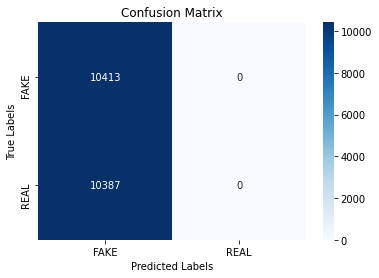

In [41]:
import sklearn
cm = sklearn.metrics.confusion_matrix(y_true, y_pred, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
    

## Transfer learning - Dataset 1

In [ ]:
best_model = BERT().to(device)

load_checkpoint(os.path.join(PATH, "Dataset3/") + '/model.pt', best_model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== /content/gdrive/My Drive/FakeNewsDetection/Dataset2//model.pt


0.015484609582449967

In [ ]:
import csv
csv.field_size_limit(250000)

131072

In [ ]:
train, valid, test = TabularDataset.splits(path=os.path.join(PATH, "Dataset"), train='train.csv', validation='train.csv',
                                           test='train.csv', format='CSV', fields=fields, skip_header=True)

In [ ]:
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

In [ ]:
y_pred = []
y_true = []

best_model.eval()
with torch.no_grad():
    for element in test_iter:
            label = element.label
            text = element.text
            labels = label.type(torch.LongTensor)           
            labels = labels.to()
            text = text.type(torch.LongTensor)  
            text = text.to()
            output = best_model(text, labels)

            _, output = output
            y_pred.extend(torch.argmax(output, 1).tolist())
            y_true.extend(labels.tolist())
    
print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))


Classification Report:
              precision    recall  f1-score   support

           1     0.5214    0.9955    0.6844     13166
           0     0.5000    0.0049    0.0097     12088

    accuracy                         0.5213     25254
   macro avg     0.5107    0.5002    0.3470     25254
weighted avg     0.5112    0.5213    0.3614     25254



[Text(0, 0.5, 'FAKE'), Text(0, 1.5, 'REAL')]

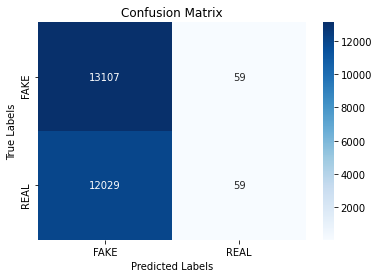

In [ ]:
import sklearn
cm = sklearn.metrics.confusion_matrix(y_true, y_pred, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
ax.yaxis.set_ticklabels(['FAKE', 'REAL'])